# ASIS

In [1]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, GridSearchCV, ShuffleSplit, cross_val_score, train_test_split, ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.preprocessing import Binarizer, StandardScaler, LabelBinarizer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, f1_score, roc_auc_score, roc_curve, auc

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import TruncatedSVD, PCA

from imblearn.over_sampling import SMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.under_sampling import TomekLinks, NearMiss, OneSidedSelection
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline

from collections import defaultdict, Counter
import itertools
import tabulate
import unicodedata
import random
import csv
import re
import mglearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
import spacy

import nltk 
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
#from wordcloud import WordCloud
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet
from nltk.stem.snowball import SnowballStemmer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings('ignore')


/Users/andricvaldez/Desktop/Maestria/3er Semestre/Tesis/Desarrollo/env2/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/andricvaldez/Desktop/Maestria/3er Semestre/Tesis/Desarrollo/env2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/andricvaldez/nltk_d

In [2]:
moreStopWords=[
 '`', '``', 'trunk', 'while', 'case', 'switch','def', 'abstract','byte','continue','native','private','synchronized',
 'if', 'do', 'include', 'each', 'than', 'finally', 'class', 'double', 'float', 'int','else','instanceof',
 'long', 'super', 'import', 'short', 'default', 'catch', 'try', 'new', 'final', 'extends', 'implements',
 'public', 'protected', 'static', 'this', 'return', 'char', 'const', 'break', 'boolean', 'bool', 'package',
 'byte', 'assert', 'raise', 'global', 'with', 'or', 'yield', 'in', 'out', 'except', 'and', 'enum', 'signed',
 'void', 'virtual', 'union', 'goto', 'var', 'function', 'require', 'print', 'echo', 'foreach', 'elseif', 'namespace',
 'delegate', 'event', 'override', 'struct', 'readonly', 'explicit', 'interface', 'get', 'set','elif','for',
 'throw','throws','lambda','endfor','endforeach','endif','endwhile','clone'
] 


# Load Dataset

In [3]:
def readDataset(dataset):
    dataset = pd.read_csv('Datasets/' + dataset, encoding = "ISO-8859-1", engine='python', dtype=str)
    return dataset


# Normalization

In [4]:
class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.stopwords = stopwords.words('english')
        self.stopwords.extend(moreStopWords)
        self.stopwords.extend(list(string.punctuation))
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = SnowballStemmer("english")
        self.emodict=[]
        with open("emoticonsTable.txt","r") as emotable:
            emoticon_reader=csv.reader(emotable,delimiter='\t')
            self.emodict={rows[0]:rows[1] for rows in emoticon_reader}
            emotable.close()

    def isPunct(self, token): 
        return all(unicodedata.category(char).startswith('P') for char in token)
    
    def isStopword(self, token):
        return token.lower() in self.stopwords
    
    def handleStopw(self, data):
        return ' '.join([i for i in word_tokenize(data.lower()) if i not in self.stopwords])
    
    def handleEmoticons(self, text, dic):
        for i, j in dic.items():
            text = text.replace(i, j)
        return text
    
    def replaceText(self, s):
        clean_text = s.replace('\n','') # remove whitespaces
        clean_text = s.replace('\t','')
        clean_text = re.sub(r'http\S+', 'URL', str(clean_text)) # Replace url
        clean_text = re.sub(r'\+\d{1}', 'LIKE', str(clean_text)) # Replace +1
        clean_text = re.sub(r'\[~\S+\]', 'USER', str(clean_text)) # # Replace username [~kdvolder]
        clean_text = re.sub(r'[\d]+.[\d]+\S*', 'VERSION', str(clean_text)) # Replace software versions
        clean_text = re.sub(r'\{code.*\{code}', 'CODE', str(clean_text)) # Replace all code snippets,  in Jira comments is found ---> {code} some code... {code}
        clean_text = re.sub(r'\{noformat.*\{noformat}', 'CODE', str(clean_text)) # Replace all code snippets,  in Jira is ---> {noformat} some code... {noformat}
        clean_text = re.sub(r'\{{.*\}}', 'CODE', str(clean_text)) # Replace all pattern {{ }} refers to variables/functions
        clean_text = re.sub(r'\{quote.*\{quote}', 'QUOTE', str(clean_text)) # Replace all quotes (it is used for reference variables or code)
        return clean_text

    def handleContractions(self, phrase):
        # specific
        phrase = re.sub(r"won\'t", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)
        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
        return phrase
    
    def removeSpecialCharacters(self, text):
        pattern = r'[^a-zA-z\s]'
        text = re.sub(pattern, '', text)
        return text
    
    def tokenizePOS(self, issue):
        issue = issue.lower()   
        for sent in sent_tokenize(issue):
            return pos_tag(wordpunct_tokenize(sent)) 
    
    def nltkTagToTordnetTag(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:          
            return None
    
    def preprocessing(self, issueCom, norm='stem'): 
        response = []
        text = str(issueCom)
        comment = self.replaceText(text)
        comment = self.handleEmoticons(comment, self.emodict) 
        comment = self.handleContractions(comment)
        comment = self.handleStopw(comment)
        comment = self.removeSpecialCharacters(comment)
        comment = [word for word in nltk.word_tokenize(comment.lower())]
        comment = nltk.pos_tag(comment) 

        for (word, tag) in comment if comment is not None else '':
            if (self.isPunct(word) or self.isStopword(word)):
                continue  
            if norm == 'lem':
                if tag is None:
                    response.append(word)
                else:        
                    response.append(self.lemmatizer.lemmatize(word, tag).lower())
            elif norm == 'stem':
                response.append(self.stemmer.stem(word))
            else:
                response.append(word)
         
        return response
    
    
    def fit(self, X, y=None): 
        return self
    
    def transform(self, issues): 
        response = []
        for issue in issues:
            data = self.preprocessing(issue)
            response.append(data)
        return response
    

# Model - Pipeline

In [5]:
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self
    
def identity_tokenizer(text):
    return text

def create_pipeline(estimator, mayorityClassNumber, imbalance = True):
    steps = [
        ('normalize', TextNormalizer()),
        ('vectorize', TfidfVectorizer(
            tokenizer=identity_tokenizer, 
            preprocessor=None, 
            lowercase=False,
            sublinear_tf=True,
            max_df = 0.50,
            min_df = 2,
            ngram_range = (1, 1)
            )
        ),
        #('todense', DenseTransformer()), 
    ]
    
    if imbalance:
        steps.append(('oversampling', SVMSMOTE( 
            k_neighbors=15, 
            random_state=42, 
            sampling_strategy={'-1': int(mayorityClassNumber*.6), '1': int(mayorityClassNumber*.6)}
            )
        ))
        
        #steps.append(('undersampling', TomekLinks(
        #    random_state=42,
        #    sampling_strategy='majority'
        #    )
        #))

    steps.append(('estimator', estimator))
    
    return Pipeline(steps)

# Train model

In [6]:
def trainModel(classifier):
    mayorityClassNumber = 3886 # pending to calculate
    print('Trainning Model...')
    dataset_jira = readDataset('datasetJIRA.csv')
    X, y = dataset_jira['Sentence'], dataset_jira['Label']
    pipe = create_pipeline(classifier, mayorityClassNumber, True).fit(X,y)
    print('Done!')
    return pipe


classifier = GradientBoostingClassifier(criterion='friedman_mse',init=None,learning_rate=0.1,
                            loss='deviance',max_depth=3,max_features=None,
                            max_leaf_nodes=None,min_impurity_decrease=0.0,
                            min_impurity_split=None,min_samples_leaf=1,
                            min_samples_split=2,min_weight_fraction_leaf=0.0,
                            n_estimators=100,n_iter_no_change=None,presort='auto',
                            random_state=42,subsample=1.0,tol=0.0001,
                            validation_fraction=0.1,verbose=0,warm_start=False)

train_model = trainModel(classifier)


'''
text = "Sorry for the delay! Can you send the output of running: {code} > db.mycoll.getIndexes() > db.mycoll2.getIndexes() > db.system.namespaces.find() {code} Also, if you can try initial syncing with {{-vvvvv}} and pasting the logs, it would be very helpful."
norm = TextNormalizer()
data = norm.fit_transform([text])
print(list(data))

sent = int(train_model.predict([text]))
sent
'''

Trainning Model...
Done!


'\ntext = "Sorry for the delay! Can you send the output of running: {code} > db.mycoll.getIndexes() > db.mycoll2.getIndexes() > db.system.namespaces.find() {code} Also, if you can try initial syncing with {{-vvvvv}} and pasting the logs, it would be very helpful."\nnorm = TextNormalizer()\ndata = norm.fit_transform([text])\nprint(list(data))\n\nsent = int(train_model.predict([text]))\nsent\n'


# Predict Sentimients

In [7]:
# return list of sentiments for issue comments
def predictSentiments(issuesData, train_model):  
    print('Predicting sentiments...')
    sentimentScores = []
    for index, row in issuesData.iterrows():    
        comment = str(row.comment)
        sent = int(train_model.predict([comment]))
        sentimentScores.append(sent) 
    
    print('Done!')   
    return sentimentScores

#*************** testing (for in individual server and project)
'''server = 'APACHE'
project = 'CASSANDRA'
issuesData = pd.read_csv('repoData/ISSUES-COMMENTS-' + server + '-' + project + '.csv')
print('Number of comments:', len(issuesData))
issuesData["sentiment"] = predictSentiments(issuesData, train_model)
issuesData.to_csv('repoDataSA/ISSUES-COMMENTS-' + server + '-' + project + '.csv', encoding='utf-8', header=True, index=False)
print(issuesData['sentiment'].value_counts('1')*100)
issuesData.head()'''

'server = \'APACHE\'\nproject = \'CASSANDRA\'\nissuesData = pd.read_csv(\'repoData/ISSUES-COMMENTS-\' + server + \'-\' + project + \'.csv\')\nprint(\'Number of comments:\', len(issuesData))\nissuesData["sentiment"] = predictSentiments(issuesData, train_model)\nissuesData.to_csv(\'repoDataSA/ISSUES-COMMENTS-\' + server + \'-\' + project + \'.csv\', encoding=\'utf-8\', header=True, index=False)\nprint(issuesData[\'sentiment\'].value_counts(\'1\')*100)\nissuesData.head()'

In [240]:
#*************** Predict Sentiment for all servers and projects (batch)

servers_projects = [
                'APACHE-AAR', 'APACHE-ABDERA', 'APACHE-ACCUMULO', 'APACHE-ACE', 'APACHE-AMQNET', 'APACHE-ATLAS', 
                'APACHE-BEAM', 'APACHE-BIGTOP', 'APACHE-CASSANDRA', 'APACHE-DIRSERVER', 'APACHE-FELIX', 'APACHE-GUMP',
                'APACHE-IGNITE', 'APACHE-MAPREDUCE', 'APACHE-MATH', 'APACHE-STORM', 'APACHE-HADOOP',
                'ATLASSIAN-API', 'ATLASSIAN-BAM', 'ATLASSIAN-BCLOUD', 'ATLASSIAN-CLOUD', 'ATLASSIAN-CLOV', 
                'ATLASSIAN-CRUC', 'ATLASSIAN-CWD', 'ATLASSIAN-FE', 'ATLASSIAN-HCPUB', 'ATLASSIAN-JRACLOUD', 
                'ATLASSIAN-JRASERVER', 'ATLASSIAN-JSDCLOUD', 'ATLASSIAN-JSDSERVER', 'ATLASSIAN-SRCTREE', 
                'JBOSS-AEROGEAR', 'JBOSS-AF', 'JBOSS-ARQ', 'JBOSS-AS7', 'JBOSS-DROOLS', 'JBOSS-ENTMQBR', 
                'JBOSS-EXOJCR', 'JBOSS-FABRIC', 'JBOSS-FH', 'JBOSS-FORGE', 'JBOSS-FUSETOOLS', 'JBOSS-GTNPORTAL', 
                'JBOSS-JBAS', 'JBOSS-JBESB', 'JBOSS-JBPAPP', 'JBOSS-JBTM', 'JBOSS-RHBPMS', 
                'MONGO-CSHARP', 'MONGO-HADOOP', 'MONGO-JAVA', 'MONGO-MONGOID', 'MONGO-NODE', 'MONGO-PHP', 
                'MONGO-PYTHON', 'MONGO-RUBY', 'MONGO-SERVER', 'MONGO-TOOLS', 'MONGO-WT', 
                'SPRING-AMQP', 'SPRING-BATCH', 'SPRING-BATCHADM', 'SPRING-DATACMNS', 'SPRING-DATAGRAPH', 
                'SPRING-DATAMONGO', 'SPRING-GRADLE', 'SPRING-GREENHOUSE', 'SPRING-IDE', 'SPRING-INT', 
                'SPRING-ROO', 'SPRING-SGF', 'SPRING-SHDP', 'SPRING-SLICE', 'SPRING-SOCIAL', 'SPRING-SPRNET', 
                'SPRING-STS', 'SPRING-XD'
                ]

for s_p in servers_projects:
    print(s_p)
    issuesData = pd.read_csv('repoData/ISSUES-COMMENTS-' + s_p + '.csv')
    issuesData["sentiment"] = predictSentiments(issuesData, train_model)
    issuesData.to_csv('repoDataSA/ISSUES-COMMENTS-' + s_p + '.csv', encoding='utf-8', header=True, index=False)




APACHE-AAR
Predicting sentiments...
Done!
APACHE-ABDERA
Predicting sentiments...
Done!
APACHE-ACCUMULO
Predicting sentiments...
Done!
APACHE-ACE
Predicting sentiments...
Done!
APACHE-AMQNET
Predicting sentiments...
Done!
APACHE-ATLAS
Predicting sentiments...
Done!
APACHE-BEAM
Predicting sentiments...
Done!
APACHE-BIGTOP
Predicting sentiments...
Done!
APACHE-CASSANDRA
Predicting sentiments...
Done!
APACHE-DIRSERVER
Predicting sentiments...
Done!
APACHE-FELIX
Predicting sentiments...
Done!
APACHE-GUMP
Predicting sentiments...
Done!
APACHE-IGNITE
Predicting sentiments...
Done!
APACHE-MAPREDUCE
Predicting sentiments...
Done!
APACHE-MATH
Predicting sentiments...
Done!
APACHE-STORM
Predicting sentiments...
Done!
APACHE-HADOOP
Predicting sentiments...
Done!
ATLASSIAN-API
Predicting sentiments...
Done!
ATLASSIAN-BAM
Predicting sentiments...
Done!
ATLASSIAN-BCLOUD
Predicting sentiments...
Done!
ATLASSIAN-CLOUD
Predicting sentiments...
Done!
ATLASSIAN-CLOV
Predicting sentiments...
Done!
ATLASSIA

# Evaluate Model Performance (Cross Validation: Prec, Rec, Fs, Acc)

In [37]:

mayorityClassNumber = 2931 #pending to calculate
models = []
classifiers = [
    GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False),
    #GradientBoostingClassifier(criterion='friedman_mse',init=None,learning_rate=0.1,
    #                        loss='deviance',max_depth=3,max_features=None,
    #                        max_leaf_nodes=None,min_impurity_decrease=0.0,
    #                        min_impurity_split=None,min_samples_leaf=1,
    #                        min_samples_split=2,min_weight_fraction_leaf=0.0,
    #                        n_estimators=100,n_iter_no_change=None,presort='auto',
    #                        random_state=42,subsample=1.0,tol=0.0001,
    #                        validation_fraction=0.1,verbose=0,warm_start=False),
    #RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
    #                       max_depth=None, max_features='auto', max_leaf_nodes=None,
    #                       min_impurity_decrease=0.0, min_impurity_split=None,
    #                       min_samples_leaf=1, min_samples_split=5,
    #                       min_weight_fraction_leaf=0.0, n_estimators=200,
    #                       n_jobs=None, oob_score=False, random_state=None,
    #                       verbose=0, warm_start=False),
    #LogisticRegression(),
    #LinearSVC(),
    #SGDClassifier(),
    #KNeighborsClassifier(),
    #DecisionTreeClassifier(),
    #BernoulliNB()
    #MultinomialNB(),
    #GaussianNB(),
]

for classifier in classifiers:
    models.append(create_pipeline(classifier, mayorityClassNumber, True))


In [38]:

fields = ["model", 'precision', 'recall', 'f1', 'micro_avg', 'macro_avg', 'accuracy']
labels = ['-1', '0', '1']
    
def evaluateModels(folds=10, shuffle=False, dset='datasetJIRA.csv'):
    kf = KFold(n_splits=folds, shuffle=shuffle)
    dataset = readDataset(dset)
    modelNum = 1
    for model in models: 
        table  = []
        class_metrics = {'neg': {'pre': [], 'rec': [], 'f1': []}, 
                         'neu': {'pre': [], 'rec': [], 'f1': []}, 
                         'pos': {'pre': [], 'rec': [], 'f1': []},
                         'micro_avg': {'pre': [], 'rec': [], 'f1': []},
                         'macro_avg': {'pre': [], 'rec': [], 'f1': []}
                        }
        
        scores = defaultdict(list)
        splitNum = 1
        
        print("\nModel: ", str(model['estimator']))
        print("Lables: ", labels)
        print("Metrics: [[precision], micro, macro, [recall], micro, macro, [f1], micro, macro, accuracy]")
        
        for train, test in kf.split(dataset):
            X_train, y_train = dataset['Sentence'][train], dataset['Label'][train]
            X_test, y_test = dataset['Sentence'][test], dataset['Label'][test]
            
            model.fit(X_train, y_train)  
            y_pred = model.predict(X_test)
            
            precision = precision_score(y_test, y_pred, average=None)
            recall    = recall_score(y_test, y_pred, average=None)
            f1        = f1_score(y_test, y_pred, average=None)
            accuracy  = accuracy_score(y_test, y_pred)
            
            precision_micro = precision_score(y_test, y_pred, average='micro')
            recall_micro    = recall_score(y_test, y_pred, average='micro')
            f1_micro        = f1_score(y_test, y_pred, average='micro')
            
            precision_macro = precision_score(y_test, y_pred, average='macro')
            recall_macro    = recall_score(y_test, y_pred, average='macro')
            f1_macro        = f1_score(y_test, y_pred, average='macro')

            scores['precision'].append(precision)
            scores['recall'].append(recall)
            scores['f1'].append(f1)
            scores['accuracy'].append(accuracy)    
            
            scores['precision_micro'].append(precision_micro)
            scores['recall_micro'].append(recall_micro)
            scores['f1_micro'].append(f1_micro)
            
            scores['precision_macro'].append(precision_macro)
            scores['recall_macro'].append(recall_macro)
            scores['f1_macro'].append(f1_macro)
            
            class_metrics['neg']['pre'].append(precision[0])
            class_metrics['neg']['rec'].append(recall[0])
            class_metrics['neg']['f1'].append(f1[0])
            
            class_metrics['neu']['pre'].append(precision[1])
            class_metrics['neu']['rec'].append(recall[1])
            class_metrics['neu']['f1'].append(f1[1])
            
            class_metrics['pos']['pre'].append(precision[2])
            class_metrics['pos']['rec'].append(recall[2])
            class_metrics['pos']['f1'].append(f1[2])
            
            class_metrics['micro_avg']['pre'].append(precision_micro)
            class_metrics['micro_avg']['rec'].append(recall_micro)
            class_metrics['micro_avg']['f1'].append(f1_micro)
            
            class_metrics['macro_avg']['pre'].append(precision_macro)
            class_metrics['macro_avg']['rec'].append(recall_macro)
            class_metrics['macro_avg']['f1'].append(f1_macro)
            
            print("***** Split-" + str(splitNum) + " -> ", 
                  [round(prec, 2) for prec in precision.tolist()], 
                  round(precision_micro, 2),
                  round(precision_macro, 2),
                  [round(rec, 2) for rec in recall.tolist()], 
                  round(recall_micro, 2),
                  round(recall_macro, 2),
                  [round(f, 2) for f in f1.tolist()], 
                  round(f1_micro, 2),
                  round(f1_macro, 2),
                  round(accuracy, 2)
            )

            print('')
            splitNum+=1            
            
        row = [str(modelNum)]
        for field in fields[1:]:
            row.append(np.mean(scores[field]))
        table.append(row)
        modelNum+=1
    
        print("cla", 'Precis', 'Recall', 'F1Score')
        print('----------------------------------------')
        for key, value in class_metrics.items():
            print(key, 
                  round(sum(value['pre'])/len(value['pre']) * 100, 4),
                  round(sum(value['rec'])/len(value['rec']) * 100, 4),
                  round(sum(value['f1'])/len(value['f1']) * 100, 4)
            ) if len(value['pre']) and len(value['rec']) and len(value['f1']) > 0 else 0
    
        print('\n')
        print(tabulate.tabulate(table, headers=fields))
   

corpus = 'datasetJIRA.csv' 
mayorityClassNumber = 0
shuffle = True
kfolds = 10

evaluateModels(kfolds, imbalance, corpus)


Model:  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Lables:  ['-1', '0', '1']
Metrics: [[precision], micro, macro, [recall], micro, macro, [f1], micro, macro, accuracy]
***** Split-1 ->  [0.78, 0.89, 0.78] 0.85 0.81 [0.58, 0.89, 0.86] 0.85 0.78 [0.66, 0.89, 0.81] 0.85 0.79 0.85

***** Split-2 ->  [0.89, 0.89, 0.74] 0.86 0.84 [0.63, 0.9, 0.87] 0.86 0.8 [0.74, 0.9, 0

# Evaluate Model Performance (Conf Matrix, RocAuc Scores)

              precision    recall  f1-score   support

          -1   0.807339  0.633094  0.709677       278
           0   0.887160  0.887850  0.887505      1284
           1   0.755102  0.871728  0.809235       382

    accuracy                       0.848251      1944
   macro avg   0.816534  0.797557  0.802139      1944
weighted avg   0.849795  0.848251  0.846695      1944

             precision    recall  f1-score  support    pred       AUC
-1            0.807339  0.633094  0.709677    278.0   218.0  0.904180
0             0.887160  0.887850  0.887505   1284.0  1285.0  0.886380
1             0.755102  0.871728  0.809235    382.0   441.0  0.938154
avg / total   0.849795  0.848251  0.846695   1944.0  1944.0  0.932955


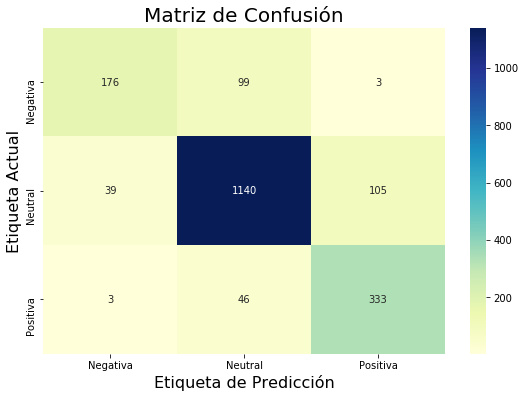

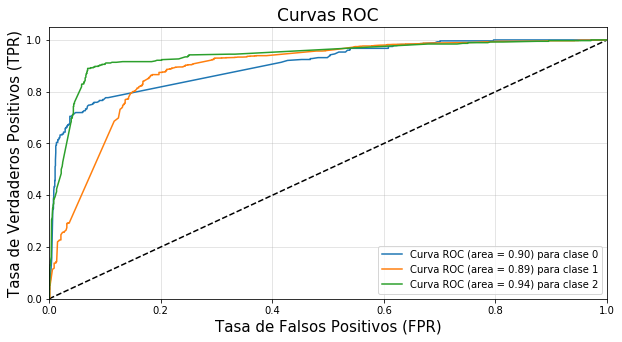

In [84]:


def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(15, 5)):
    #y_score = clf.decision_function(X_test)
    y_score = clf.predict_proba(X_test)


    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Tasa de Falsos Positivos (FPR)', fontsize=15)
    ax.set_ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=15)
    ax.set_title('Curvas ROC', fontsize=17)
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='Curva ROC (area = %0.2f) para clase %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    plt.show()
    
def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Read dataset
mayorityClassNumber = 2931 
dataset_jira = readDataset('datasetJira.csv')
X, y = dataset_jira['Sentence'], dataset_jira['Label']

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.33, random_state=0)

# Get classifiers
classifier = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                       learning_rate=0.1, loss='deviance', max_depth=3,
                                       max_features=None, max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0, n_estimators=100,
                                       n_iter_no_change=None, presort='auto',
                                       random_state=None, subsample=1.0, tol=0.0001,
                                       validation_fraction=0.1, verbose=0,
                                       warm_start=False)

pipe = create_pipeline(classifier, mayorityClassNumber, True).fit(X_train, y_train)

sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=pipe.predict(X_test))
print(sk_report)

report_with_auc = class_report(
    y_true=y_test, 
    y_pred=pipe.predict(X_test), 
    y_score=pipe.predict_proba(X_test))
print(report_with_auc)

labels = ['Negativa', 'Neutral', 'Positiva']

'''scores_image = mglearn.tools.heatmap(
        confusion_matrix(y_test, pipe.predict(X_test)), xlabel='Etiqueta de Predicción',
        ylabel='Etiqueta Actual', xticklabels=labels,
        yticklabels=labels, cmap=plt.cm.gray_r, fmt="%d")
plt.title("Matriz de Confusión")
plt.gca().invert_yaxis()'''

# Creates a confusion matrix
cm = confusion_matrix(y_test, pipe.predict(X_test))
plt.figure(figsize=(9,6))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)
ax.set_ylim(sorted(ax.get_xlim(), reverse=True))
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Actual', fontsize=16)
plt.xlabel('Etiqueta de Predicción', fontsize=16)
plt.show()


plot_multiclass_roc(pipe, X_test, y_test, n_classes=3, figsize=(10, 5))

# Params Tunning for Best Models

In [164]:
# Read dataset
dataset_jira = readDataset('datasetJira.csv')
X_train_jira, X_test_jira, y_train_jira, y_test_jira = train_test_split(dataset_jira['Sentence'], dataset_jira['Label'], random_state=0)
mayorityClassNumber = 2931 #pending to calculate

# Create the parameter grid based on the results of random search 
param_grid = [
        {
            'estimator': [RandomForestClassifier()],
            'estimator__max_depth': [50, 60, 100, None],
            'estimator__min_samples_leaf': [1, 3, 5],
            'estimator__min_samples_split': [2, 5, 10],
            'estimator__n_estimators': [10, 100, 150, 200]
        },
        #{
        #    'estimator': [GradientBoostingClassifier()],
        #    'estimator__learning_rate':  [0.01, 0.1, 0.2],
        #    'estimator__min_samples_split':  [2, 5],
        #    'estimator__min_samples_leaf':  [1, 3],
        #    'estimator__max_depth': [None, 3, 5],
        #    'estimator__n_estimators': [10, 100, 150, 200]
        #}
]

# Create pipeline
pipe = create_pipeline(RandomForestClassifier(), mayorityClassNumber, True)

# Instantiate the grid search model
grid_search = GridSearchCV(pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = None, verbose = 2,
                          scoring = ['accuracy', 'precision_macro','recall_macro', 'f1_macro'], 
                          refit='f1_macro')

grid_search.fit(X_train_jira, y_train_jira)
print(grid_search.best_params_)



Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10, total=  16.4s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.4s remaining:    0.0s


[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10, total=  18.4s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_e

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=150, total=  18.6s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=  19.0s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=200, total=  18.1s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=  17.3s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10, total=  15.8s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=150, total=  17.0s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10, total=  16.6s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_e

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=200, total=  17.0s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=3, estimator__min_samples_split=10, estimator__n_estimators=100, total=  16.7s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=3, estimator__min_samples_split=10, estimator__n_estimators=200, total=  17.5s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=150, total=  16.5s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=5, estimator__min_samples_split=5, estimator__n_estimators=10, total=  16.2s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_e

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=5, estimator__min_samples_split=5, estimator__n_estimators=150, total=  17.3s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=100, total=  16.2s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0,

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=50, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=200, total=  17.1s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=50, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=100, total=  18.4s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10, total=  15.9s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=150, total=  17.8s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=10, total=  16.5s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, 

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=200, total=  17.7s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100, total=  16.8s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=200, total=  17.7s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=150, total=  16.6s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=3, estimator__min_samples_split=10, estimator__n_estimators=10, total=  16.1s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, 

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=3, estimator__min_samples_split=10, estimator__n_estimators=150, total=  17.4s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=100, total=  16.5s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=200, total=  17.2s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=5, estimator__min_samples_split=5, estimator__n_estimators=100, total=  16.9s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=10, total=  15.7s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, 

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=60, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=150, total=  17.0s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=60, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=10, total=  16.6s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, 

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=200, total=  18.9s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=100, total=  17.4s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=200, total=  19.0s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=150, total=  17.5s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=10, total=  16.5s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, 

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=150, total=  17.5s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=100, total=  16.4s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0,

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=200, total=  17.5s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=3, estimator__min_samples_split=10, estimator__n_estimators=100, total=  17.1s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=10, total=  15.8s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=150, total=  17.0s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=5, estimator__min_samples_split=5, estimator__n_estimators=10, total=  16.4s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, 

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=5, estimator__min_samples_split=5, estimator__n_estimators=200, total=  16.9s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=100, total=  16.7s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=100, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=200, total=  17.7s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=100, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=2, estimator__n_estimators=150, total=  18.7s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=10, total=  16.3s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=5, estimator__n_estimators=150, total=  18.9s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=100, total=  17.1s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_lea

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=1, estimator__min_samples_split=10, estimator__n_estimators=200, total=  19.2s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_le

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=3, estimator__min_samples_split=2, estimator__n_estimators=100, total=  17.1s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=10, total=  15.8s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=3, estimator__min_samples_split=5, estimator__n_estimators=150, total=  17.2s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=5,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=3, estimator__min_samples_split=10, estimator__n_estimators=10, total=  16.5s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=3, estimator__min_samples_split=10, estimator__n_estimators=200, total=  17.3s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_le

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=100, total=  16.7s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=2, estimator__n_estimators=200, total=  17.6s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=5, estimator__n_estimators=150, total=  16.6s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=5,
                       min_weight_fraction_leaf=

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=10, total=  16.8s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf

[CV]  estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), estimator__max_depth=None, estimator__min_samples_leaf=5, estimator__min_samples_split=10, estimator__n_estimators=150, total=  17.4s
[CV] estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=10,
                       min_weight_fraction_le

[Parallel(n_jobs=1)]: Done 432 out of 432 | elapsed: 123.4min finished


{'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False), 'estimator__max_depth': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 200}


# Debugging Model 

In [211]:
import eli5

dataset_jira = readDataset('datasetJira.csv')
X_train_jira, X_test_jira, y_train_jira, y_test_jira = train_test_split(dataset_jira['Sentence'], dataset_jira['Label'], random_state=0)

# Preprocessing dataset
tm = TextNormalizer().fit(X_train_jira)
nomalizeText = tm.transform(X_train_jira)
X_train_jira_NORM = []
for t in nomalizeText:
    X_train_jira_NORM.append(' '.join(t))

ve = TfidfVectorizer(
            preprocessor=None, 
            lowercase=False,
            sublinear_tf=True,
            max_df = 0.50,
            min_df = 2,
            ngram_range = (1, 1)
    )

cl = GradientBoostingClassifier(criterion='friedman_mse',init=None,learning_rate=0.1,
                            loss='deviance',max_depth=3,max_features=None,
                            max_leaf_nodes=None,min_impurity_decrease=0.0,
                            min_impurity_split=None,min_samples_leaf=1,
                            min_samples_split=2,min_weight_fraction_leaf=0.0,
                            n_estimators=100,n_iter_no_change=None,presort='auto',
                            random_state=42,subsample=1.0,tol=0.0001,
                            validation_fraction=0.1,verbose=0,warm_start=False)

pipe = make_pipeline(ve, cl)
pipe.fit(X_train_jira_NORM, y_train_jira)


Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=False, max_df=0.5, max_features=None,
                                 min_df=2, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=True,
                                 token...
                                            learning_rate=0.1, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
          

In [212]:
tm = TextNormalizer().fit(X_train_jira)
texts = ['thanks for reporting the issue. Processing-timebased windows internally uses a ScheduledExecutor.']
index = 0
text = ' '.join(tm.transform([texts[index]])[0])

eli5.show_prediction(cl, 
                     text,
                     vec=ve,
                     target_names=['-1', '0', '1'],
                     top=5
)

In [213]:
eli5.show_weights(cl, vec=ve, top=50,
                  target_names=[-1,1,0])

Weight,Feature
0.3995 ± 0.3811,thank
0.1881 ± 0.2788,sorri
0.0733 ± 0.1559,good
0.0398 ± 0.1557,bad
0.0200 ± 0.1513,hell
0.0190 ± 0.1529,suck
0.0172 ± 0.1524,positivesenti
0.0172 ± 0.1564,great
0.0138 ± 0.1488,damn
0.0125 ± 0.1469,shit
